# MLP
Like MLP_207. 

Exclude the middle from train but not test.

In [70]:
from datetime import datetime
print(datetime.now())

2023-03-28 15:08:14.467259


In [71]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [72]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = True
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [73]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [74]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [75]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [76]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [77]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-28 15:08:15.587354
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 64)                65664     
                                                                 
 dense_145 (Dense)           (None, 64)                4160      
                                                                 
 dense_146 (Dense)           (None, 64)                4160      
                                                                 
 dense_147 (Dense)           (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [78]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [79]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-28 15:08:15.778453
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-28 15:08:36.222145

Training # 1 1
2023-03-28 15:08:36.223820
2023-03-28 15:08:36.223894
Discriminator ZERO -1
Train 1:0 757:668 53.12%
Computed class weights: {0: 1.0666167664670658, 1: 0.9412153236459709}
Valid 1:0 458:412 52.64%
FIT
2023-03-28 15:08:36.290961


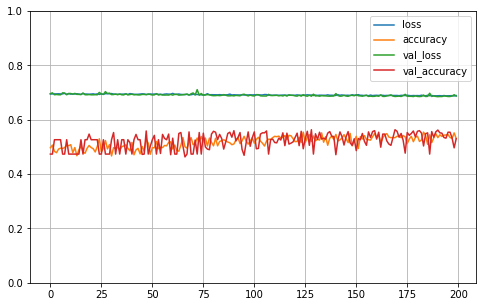


2023-03-28 15:09:59.515400

Testing # 1 1
2023-03-28 15:09:59.515825
2023-03-28 15:09:59.515872
PREDICT
2023-03-28 15:09:59.531252
Test 1:0 458:412 52.64%
Predict 1:0 531:339 61.03%
Test sizes (870, 1025) (870,)
Range of scores: 0.27162477 to 0.5352198
Score threshold 0.5
Confusion matrix
 [[171 241]
 [168 290]]
Normalized matrix
 [[0.19655172 0.27701149]
 [0.19310345 0.33333333]]


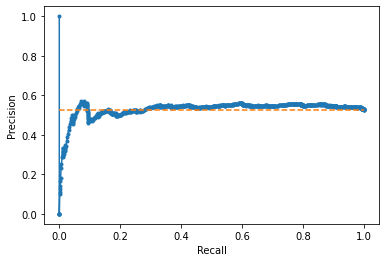

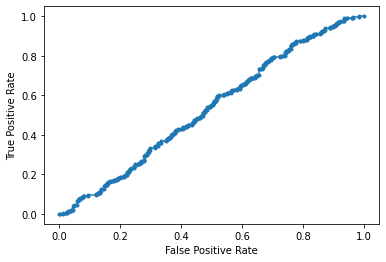

Accuracy: 52.99% Precision: 54.61% Recall: 63.32%
F1: 58.65% MCC: 0.0494
AUPRC: 53.03% AUROC: 53.37%
 accuracy [52.98850574712644]
 precision [54.61393596986818]
 recall [63.31877729257642]
 F1 [58.64509605662286]
 MCC [0.04938651427376882]
 AUPRC [53.029295656013666]
 AUROC [53.36679102895663]
2023-03-28 15:10:00.108656

Training # 1 2
2023-03-28 15:10:00.108863
2023-03-28 15:10:00.108921
Discriminator ZERO -1
Train 1:0 742:639 53.73%
Computed class weights: {0: 1.0805946791862284, 1: 0.9305929919137467}
Valid 1:0 442:442 50.00%
FIT
2023-03-28 15:10:00.198076


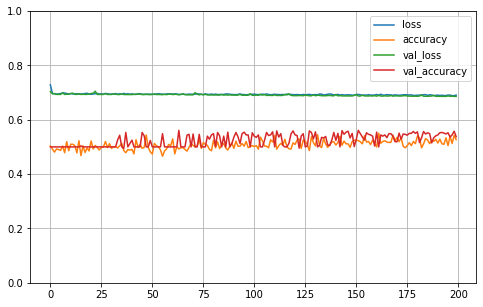


2023-03-28 15:10:45.192870

Testing # 1 2
2023-03-28 15:10:45.192998
2023-03-28 15:10:45.193043
PREDICT
2023-03-28 15:10:45.204683
Test 1:0 442:442 50.00%
Predict 1:0 451:433 51.02%
Test sizes (884, 1025) (884,)
Range of scores: 0.3260976 to 0.5289502
Score threshold 0.5
Confusion matrix
 [[233 209]
 [200 242]]
Normalized matrix
 [[0.26357466 0.23642534]
 [0.22624434 0.27375566]]


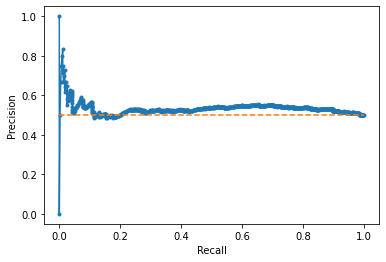

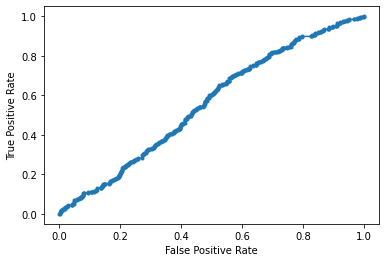

Accuracy: 53.73% Precision: 53.66% Recall: 54.75%
F1: 54.20% MCC: 0.0747
AUPRC: 53.34% AUROC: 55.73%
 accuracy [53.73303167420814]
 precision [53.65853658536586]
 recall [54.75113122171946]
 F1 [54.19932810750281]
 MCC [0.07467611584653328]
 AUPRC [53.33962670760779]
 AUROC [55.73416801457791]
2023-03-28 15:10:45.783275

Training # 1 3
2023-03-28 15:10:45.783518
2023-03-28 15:10:45.783573
Discriminator ZERO -1
Train 1:0 750:670 52.82%
Computed class weights: {0: 1.0597014925373134, 1: 0.9466666666666667}
Valid 1:0 442:407 52.06%
FIT
2023-03-28 15:10:45.848837


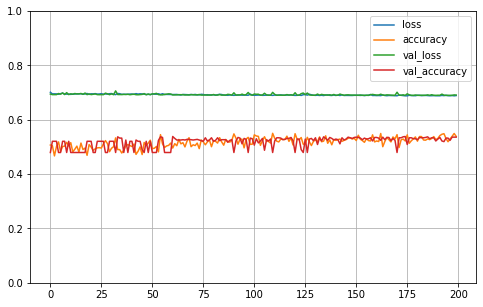


2023-03-28 15:12:56.414559

Testing # 1 3
2023-03-28 15:12:56.418732
2023-03-28 15:12:56.419140
PREDICT
2023-03-28 15:12:56.427807
Test 1:0 442:407 52.06%
Predict 1:0 520:329 61.25%
Test sizes (849, 1025) (849,)
Range of scores: 0.31276965 to 0.5387437
Score threshold 0.5
Confusion matrix
 [[171 236]
 [158 284]]
Normalized matrix
 [[0.20141343 0.27797409]
 [0.1861013  0.33451119]]


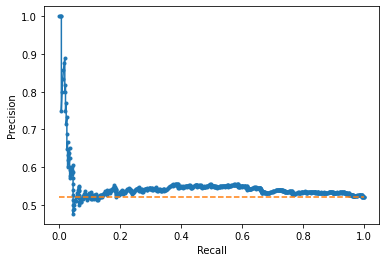

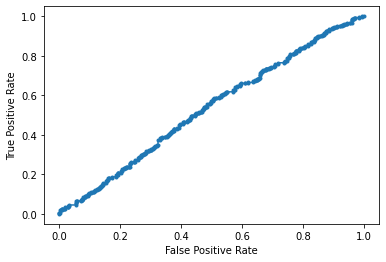

Accuracy: 53.59% Precision: 54.62% Recall: 64.25%
F1: 59.04% MCC: 0.0643
AUPRC: 54.74% AUROC: 53.37%
 accuracy [53.592461719670204]
 precision [54.61538461538461]
 recall [64.25339366515837]
 F1 [59.04365904365905]
 MCC [0.06427574322471029]
 AUPRC [54.7445858419372]
 AUROC [53.36559307147542]
2023-03-28 15:12:57.356894

Training # 1 4
2023-03-28 15:12:57.359050
2023-03-28 15:12:57.359455
Discriminator ZERO -1
Train 1:0 744:639 53.80%
Computed class weights: {0: 1.0821596244131455, 1: 0.9294354838709677}
Valid 1:0 459:431 51.57%
FIT
2023-03-28 15:12:57.472044


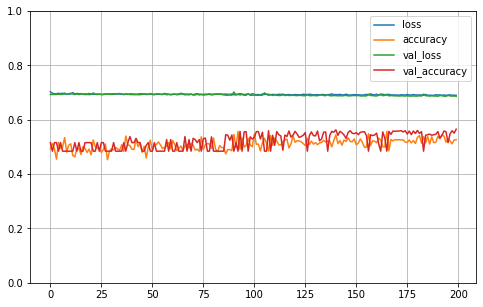


2023-03-28 15:14:21.370061

Testing # 1 4
2023-03-28 15:14:21.370569
2023-03-28 15:14:21.370615
PREDICT
2023-03-28 15:14:21.378622
Test 1:0 459:431 51.57%
Predict 1:0 620:270 69.66%
Test sizes (890, 1025) (890,)
Range of scores: 0.39066538 to 0.5554145
Score threshold 0.5
Confusion matrix
 [[157 274]
 [113 346]]
Normalized matrix
 [[0.17640449 0.30786517]
 [0.12696629 0.38876404]]


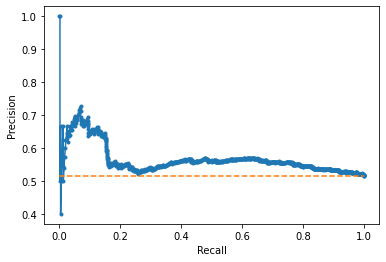

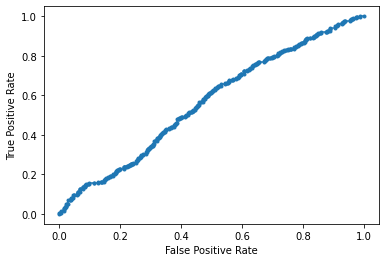

Accuracy: 56.52% Precision: 55.81% Recall: 75.38%
F1: 64.13% MCC: 0.1284
AUPRC: 56.59% AUROC: 56.37%
 accuracy [56.51685393258427]
 precision [55.80645161290323]
 recall [75.38126361655773]
 F1 [64.13345690454125]
 MCC [0.1283660370516158]
 AUPRC [56.59204116881096]
 AUROC [56.373939109028505]
2023-03-28 15:14:21.985298

Training # 1 5
2023-03-28 15:14:21.985935
2023-03-28 15:14:21.985995
Discriminator ZERO -1
Train 1:0 747:656 53.24%
Computed class weights: {0: 1.069359756097561, 1: 0.9390896921017403}
Valid 1:0 457:419 52.17%
FIT
2023-03-28 15:14:22.054074


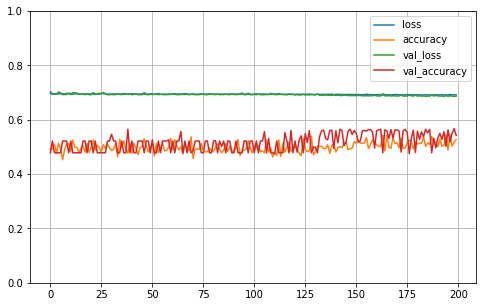


2023-03-28 15:15:07.359641

Testing # 1 5
2023-03-28 15:15:07.359783
2023-03-28 15:15:07.359832
PREDICT
2023-03-28 15:15:07.371984
Test 1:0 457:419 52.17%
Predict 1:0 594:282 67.81%
Test sizes (876, 1025) (876,)
Range of scores: 0.32599127 to 0.52526945
Score threshold 0.5
Confusion matrix
 [[150 269]
 [132 325]]
Normalized matrix
 [[0.17123288 0.30707763]
 [0.15068493 0.37100457]]


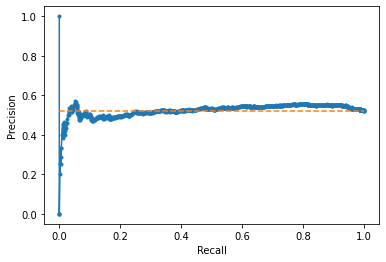

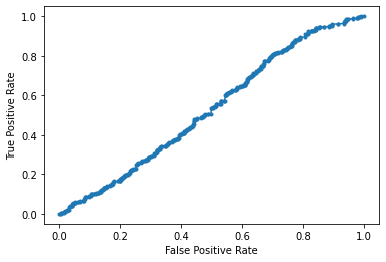

Accuracy: 54.22% Precision: 54.71% Recall: 71.12%
F1: 61.85% MCC: 0.0739
AUPRC: 52.46% AUROC: 53.03%
 accuracy [54.22374429223744]
 precision [54.71380471380471]
 recall [71.11597374179432]
 F1 [61.84586108468126]
 MCC [0.07393851015357798]
 AUPRC [52.45863777744164]
 AUROC [53.02820615929351]
2023-03-28 15:15:07.970107

Training # 2 1
2023-03-28 15:15:07.970331
2023-03-28 15:15:07.970387
Discriminator ZERO -1
Train 1:0 737:661 52.72%
Computed class weights: {0: 1.0574886535552193, 1: 0.9484396200814111}
Valid 1:0 472:415 53.21%
FIT
2023-03-28 15:15:08.043217


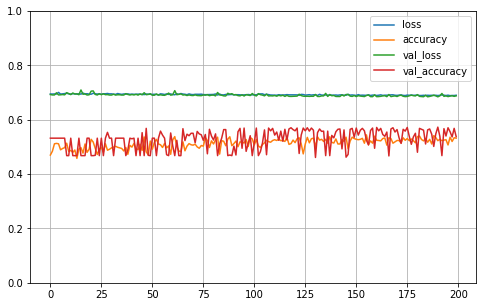


2023-03-28 15:16:31.380763

Testing # 2 1
2023-03-28 15:16:31.382411
2023-03-28 15:16:31.382813
PREDICT
2023-03-28 15:16:31.397618
Test 1:0 472:415 53.21%
Predict 1:0 494:393 55.69%
Test sizes (887, 1025) (887,)
Range of scores: 0.2655968 to 0.5287667
Score threshold 0.5
Confusion matrix
 [[199 216]
 [194 278]]
Normalized matrix
 [[0.22435175 0.24351747]
 [0.21871477 0.31341601]]


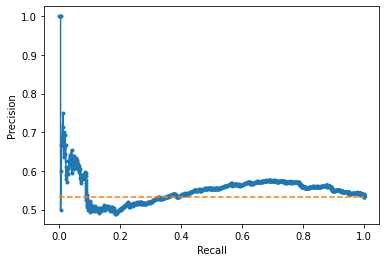

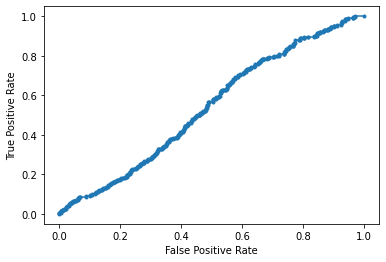

Accuracy: 53.78% Precision: 56.28% Recall: 58.90%
F1: 57.56% MCC: 0.0688
AUPRC: 55.20% AUROC: 53.94%
 accuracy [53.77677564825254]
 precision [56.2753036437247]
 recall [58.89830508474576]
 F1 [57.55693581780539]
 MCC [0.06880705819137715]
 AUPRC [55.20096467266025]
 AUROC [53.937104349601796]
2023-03-28 15:16:32.179017

Training # 2 2
2023-03-28 15:16:32.181155
2023-03-28 15:16:32.181238
Discriminator ZERO -1
Train 1:0 744:665 52.80%
Computed class weights: {0: 1.0593984962406016, 1: 0.9469086021505376}
Valid 1:0 452:416 52.07%
FIT
2023-03-28 15:16:32.250227


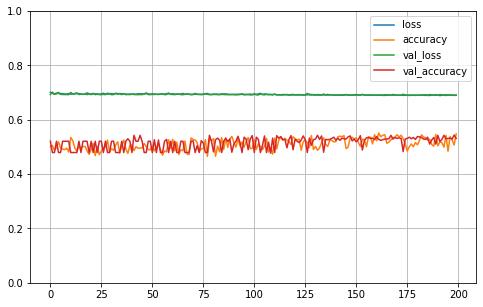


2023-03-28 15:17:55.460156

Testing # 2 2
2023-03-28 15:17:55.460265
2023-03-28 15:17:55.461136
PREDICT
2023-03-28 15:17:55.472475
Test 1:0 452:416 52.07%
Predict 1:0 647:221 74.54%
Test sizes (868, 1025) (868,)
Range of scores: 0.3229927 to 0.5287881
Score threshold 0.5
Confusion matrix
 [[115 301]
 [106 346]]
Normalized matrix
 [[0.13248848 0.34677419]
 [0.12211982 0.39861751]]


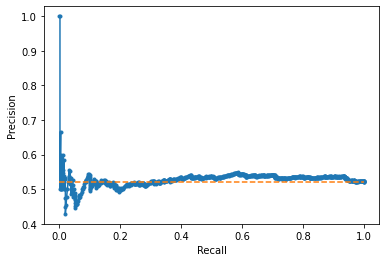

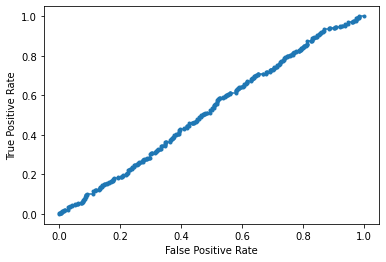

Accuracy: 53.11% Precision: 53.48% Recall: 76.55%
F1: 62.97% MCC: 0.0481
AUPRC: 52.82% AUROC: 52.19%
 accuracy [53.11059907834101]
 precision [53.47758887171561]
 recall [76.54867256637168]
 F1 [62.9663330300273]
 MCC [0.04808199242704216]
 AUPRC [52.821821553674816]
 AUROC [52.185266337644656]
2023-03-28 15:17:56.070051

Training # 2 3
2023-03-28 15:17:56.070230
2023-03-28 15:17:56.070285
Discriminator ZERO -1
Train 1:0 758:653 53.72%
Computed class weights: {0: 1.0803981623277181, 1: 0.9307387862796834}
Valid 1:0 453:407 52.67%
FIT
2023-03-28 15:17:56.145621


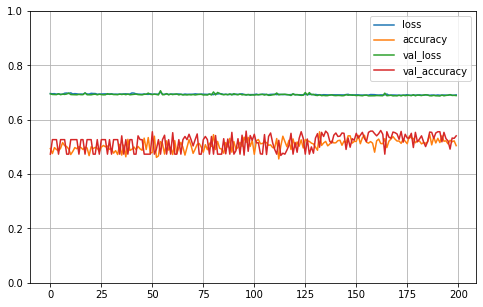


2023-03-28 15:18:39.645663

Testing # 2 3
2023-03-28 15:18:39.645814
2023-03-28 15:18:39.645860
PREDICT
2023-03-28 15:18:39.654090
Test 1:0 453:407 52.67%
Predict 1:0 564:296 65.58%
Test sizes (860, 1025) (860,)
Range of scores: 0.30865684 to 0.5316405
Score threshold 0.5
Confusion matrix
 [[154 253]
 [142 311]]
Normalized matrix
 [[0.17906977 0.29418605]
 [0.16511628 0.36162791]]


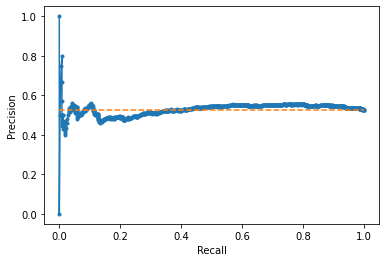

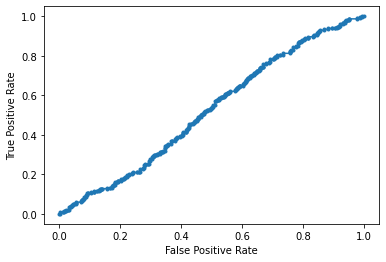

Accuracy: 54.07% Precision: 55.14% Recall: 68.65%
F1: 61.16% MCC: 0.0682
AUPRC: 52.97% AUROC: 52.41%
 accuracy [54.06976744186046]
 precision [55.14184397163121]
 recall [68.65342163355407]
 F1 [61.16027531956736]
 MCC [0.06821656819954161]
 AUPRC [52.967915055446404]
 AUROC [52.405475915409696]
2023-03-28 15:18:40.250480

Training # 2 4
2023-03-28 15:18:40.250762
2023-03-28 15:18:40.250853
Discriminator ZERO -1
Train 1:0 758:640 54.22%
Computed class weights: {0: 1.0921875, 1: 0.9221635883905013}
Valid 1:0 432:447 49.15%
FIT
2023-03-28 15:18:40.316546


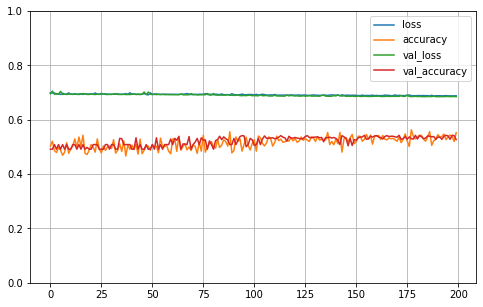


2023-03-28 15:19:26.419083

Testing # 2 4
2023-03-28 15:19:26.420832
2023-03-28 15:19:26.421232
PREDICT
2023-03-28 15:19:26.432663
Test 1:0 432:447 49.15%
Predict 1:0 586:293 66.67%
Test sizes (879, 1025) (879,)
Range of scores: 0.26132226 to 0.5393371
Score threshold 0.5
Confusion matrix
 [[162 285]
 [131 301]]
Normalized matrix
 [[0.18430034 0.32423208]
 [0.14903299 0.34243458]]


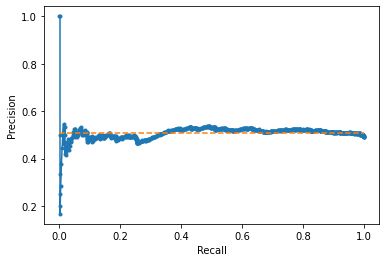

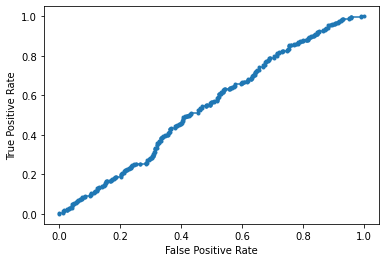

Accuracy: 52.67% Precision: 51.37% Recall: 69.68%
F1: 59.14% MCC: 0.0628
AUPRC: 50.94% AUROC: 54.39%
 accuracy [52.67349260523322]
 precision [51.365187713310576]
 recall [69.67592592592592]
 F1 [59.13555992141454]
 MCC [0.06275581502271166]
 AUPRC [50.93679833400642]
 AUROC [54.38571961222968]
2023-03-28 15:19:27.308497

Training # 2 5
2023-03-28 15:19:27.313298
2023-03-28 15:19:27.313762
Discriminator ZERO -1
Train 1:0 743:653 53.22%
Computed class weights: {0: 1.0689127105666156, 1: 0.9394347240915208}
Valid 1:0 449:426 51.31%
FIT
2023-03-28 15:19:27.419416


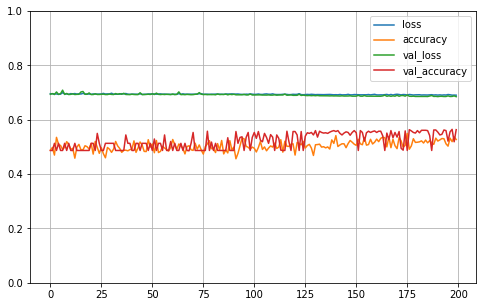


2023-03-28 15:20:50.850935

Testing # 2 5
2023-03-28 15:20:50.851047
2023-03-28 15:20:50.851090
PREDICT
2023-03-28 15:20:50.865770
Test 1:0 449:426 51.31%
Predict 1:0 657:218 75.09%
Test sizes (875, 1025) (875,)
Range of scores: 0.38112944 to 0.54469925
Score threshold 0.5
Confusion matrix
 [[131 295]
 [ 87 362]]
Normalized matrix
 [[0.14971429 0.33714286]
 [0.09942857 0.41371429]]


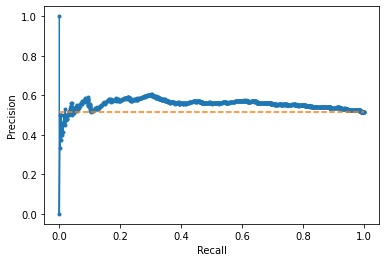

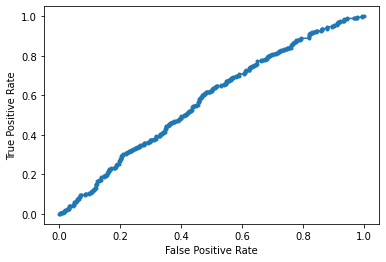

Accuracy: 56.34% Precision: 55.10% Recall: 80.62%
F1: 65.46% MCC: 0.1314
AUPRC: 55.55% AUROC: 57.43%
 accuracy [56.34285714285714]
 precision [55.09893455098934]
 recall [80.62360801781738]
 F1 [65.46112115732369]
 MCC [0.13144985461398634]
 AUPRC [55.55021765383306]
 AUROC [57.43305415268149]
2023-03-28 15:20:51.449786


In [80]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [81]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.10% std 1.32
 precision mean 54.48% std 1.39
 recall mean 68.32% std 8.12
 F1 mean 60.41% std 3.36
 MCC mean 0.08% std 0.03
 AUPRC mean 53.76% std 1.70
 AUROC mean 54.22% std 1.75
 accuracy [[52.98850574712644], [53.73303167420814], [53.592461719670204], [56.51685393258427], [54.22374429223744], [53.77677564825254], [53.11059907834101], [54.06976744186046], [52.67349260523322], [56.34285714285714]]
 precision [[54.61393596986818], [53.65853658536586], [54.61538461538461], [55.80645161290323], [54.71380471380471], [56.2753036437247], [53.47758887171561], [55.14184397163121], [51.365187713310576], [55.09893455098934]]
 recall [[63.31877729257642], [54.75113122171946], [64.25339366515837], [75.38126361655773], [71.11597374179432], [58.89830508474576], [76.54867256637168], [68.65342163355407], [69.67592592592592], [80.62360801781738]]
 F1 [[58.64509605662286], [54.19932810750281], [59.04365904365905], [64.13345690454125], [61.84586108468126], [57.55693581780539], [62.9663